In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

X_train = tf.data.Dataset

In [15]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [40]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

In [41]:
history = dropout_ae.fit(train_images, train_images, epochs=10, validation_data=(test_images, test_images))

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2544 - rounded_accuracy: 0.8777 - val_loss: 0.1563 - val_rounded_accuracy: 0.9351
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1620 - rounded_accuracy: 0.9302 - val_loss: 0.1373 - val_rounded_accuracy: 0.9456
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1489 - rounded_accuracy: 0.9375 - val_loss: 0.1290 - val_rounded_accuracy: 0.9499
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1433 - rounded_accuracy: 0.9405 - val_loss: 0.1249 - val_rounded_accuracy: 0.9521
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1387 - rounded_accuracy: 0.9430 - val_loss: 0.1215 - val_rounded_accuracy: 0.9541
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1360 - rounded_accuracy: 0.9445 - val_loss: 0.1197 - val_rounded_accuracy: 0.9551
Epoch 7/10
1875/1875 [==================

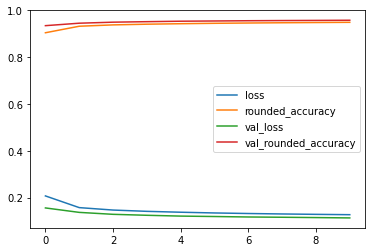

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

In [44]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

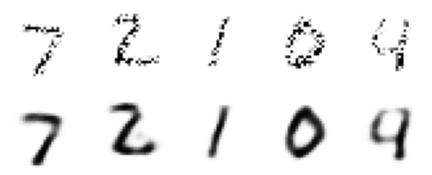

In [45]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(test_images, training=True))

In [46]:
dropout_ae.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_10 (Sequential)   (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [47]:
dropout_encoder_cln = keras.models.clone_model(dropout_encoder)
dropout_encoder_cln.set_weights(dropout_ae.layers[0].get_weights())
dropout_encoder_cln.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

In [48]:
test_codings = dropout_encoder_cln.predict(test_images)

In [49]:
test_codings.shape

(10000, 30)

In [50]:
max_per_neuron = np.argmax(test_codings, axis=0)

In [51]:
test_codings[max_per_neuron].shape

(30, 30)

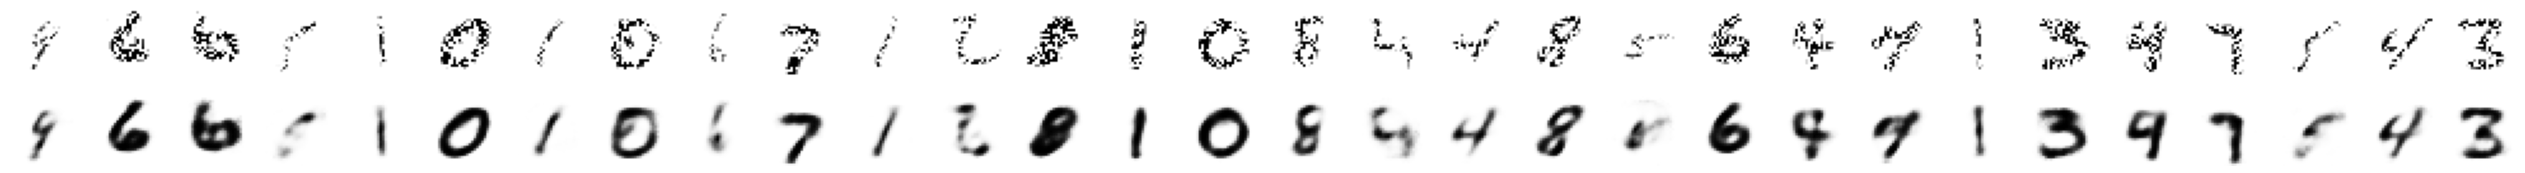

In [52]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(test_images[max_per_neuron], training=True), n_images=30)

In [61]:
X_train_small = train_images[:500]
y_train_small = train_labels[:500]

In [69]:
dropout_encoder_cln_2 = keras.models.clone_model(dropout_encoder)
plain_cls = keras.models.Sequential([
    dropout_encoder_cln_2,
    keras.layers.Dense(10, activation="softmax")
])
plain_cls.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.04), metrics=["accuracy"])

In [70]:
history = plain_cls.fit(X_train_small, y_train_small, epochs=20, validation_data=(test_images, test_labels))

Epoch 1/20
16/16 [==============================] - 1s 65ms/step - loss: 2.1877 - accuracy: 0.2449 - val_loss: 1.3035 - val_accuracy: 0.6116
Epoch 2/20
16/16 [==============================] - 1s 55ms/step - loss: 1.2045 - accuracy: 0.6605 - val_loss: 0.9551 - val_accuracy: 0.7232
Epoch 3/20
16/16 [==============================] - 1s 61ms/step - loss: 0.8521 - accuracy: 0.7518 - val_loss: 0.8311 - val_accuracy: 0.7437
Epoch 4/20
16/16 [==============================] - 1s 92ms/step - loss: 0.7272 - accuracy: 0.7696 - val_loss: 0.7797 - val_accuracy: 0.7514
Epoch 5/20
16/16 [==============================] - 1s 93ms/step - loss: 0.5411 - accuracy: 0.8686 - val_loss: 0.6911 - val_accuracy: 0.7792
Epoch 6/20
16/16 [==============================] - 1s 89ms/step - loss: 0.5661 - accuracy: 0.8103 - val_loss: 0.6607 - val_accuracy: 0.7956
Epoch 7/20
16/16 [==============================] - 1s 76ms/step - loss: 0.4709 - accuracy: 0.8602 - val_loss: 0.6313 - val_accuracy: 0.8019
Epoch 8/20
16

In [76]:
dropout_encoder_cln_3 = keras.models.clone_model(dropout_encoder)
dropout_encoder_cln_3.set_weights(dropout_ae.layers[0].get_weights())
dropout_encoder_cln_3.trainable = False
pretrn_cls = keras.models.Sequential([
    dropout_encoder_cln_3,
    keras.layers.Dense(10, activation="softmax")
])
pretrn_cls.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.04), metrics=["accuracy"])

In [77]:
history = pretrn_cls.fit(X_train_small, y_train_small, epochs=20, validation_data=(test_images, test_labels))

Epoch 1/20
16/16 [==============================] - 1s 61ms/step - loss: 6.6521 - accuracy: 0.2291 - val_loss: 2.0974 - val_accuracy: 0.4966
Epoch 2/20
16/16 [==============================] - 1s 51ms/step - loss: 1.6338 - accuracy: 0.5907 - val_loss: 1.3328 - val_accuracy: 0.6701
Epoch 3/20
16/16 [==============================] - 1s 52ms/step - loss: 0.8105 - accuracy: 0.7704 - val_loss: 1.0051 - val_accuracy: 0.7126
Epoch 4/20
16/16 [==============================] - 1s 52ms/step - loss: 0.9495 - accuracy: 0.7095 - val_loss: 1.0388 - val_accuracy: 0.7143
Epoch 5/20
16/16 [==============================] - 1s 54ms/step - loss: 0.7755 - accuracy: 0.7523 - val_loss: 0.9467 - val_accuracy: 0.7113
Epoch 6/20
16/16 [==============================] - 1s 59ms/step - loss: 0.7437 - accuracy: 0.7918 - val_loss: 1.1590 - val_accuracy: 0.6644
Epoch 7/20
16/16 [==============================] - 1s 53ms/step - loss: 0.6846 - accuracy: 0.7880 - val_loss: 1.0138 - val_accuracy: 0.7177
Epoch 8/20
16

In [78]:
dropout_encoder_cln_3.trainable = True
pretrn_cls.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.04), metrics=["accuracy"])
history = pretrn_cls.fit(X_train_small, y_train_small, epochs=20, validation_data=(test_images, test_labels))

Epoch 1/20
16/16 [==============================] - 1s 59ms/step - loss: 0.5214 - accuracy: 0.8487 - val_loss: 0.8461 - val_accuracy: 0.7643
Epoch 2/20
16/16 [==============================] - 1s 50ms/step - loss: 0.6199 - accuracy: 0.8263 - val_loss: 0.6868 - val_accuracy: 0.8074
Epoch 3/20
16/16 [==============================] - 1s 52ms/step - loss: 0.3523 - accuracy: 0.8759 - val_loss: 0.6673 - val_accuracy: 0.7968
Epoch 4/20
16/16 [==============================] - 1s 54ms/step - loss: 0.4420 - accuracy: 0.8483 - val_loss: 0.6200 - val_accuracy: 0.8180
Epoch 5/20
16/16 [==============================] - 1s 52ms/step - loss: 0.2887 - accuracy: 0.9030 - val_loss: 0.6327 - val_accuracy: 0.8031
Epoch 6/20
16/16 [==============================] - 1s 53ms/step - loss: 0.3679 - accuracy: 0.8937 - val_loss: 0.6043 - val_accuracy: 0.8224
Epoch 7/20
16/16 [==============================] - 1s 51ms/step - loss: 0.2925 - accuracy: 0.9060 - val_loss: 0.7409 - val_accuracy: 0.7901
Epoch 8/20
16